In [1]:
import os
from itertools import product
from joblib import Parallel, delayed

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests, linear_regression
from statsmodels.regression.mixed_linear_model import MixedLM
from numba import njit

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice
plt.rcParams['pdf.fonttype']=42

%matplotlib inline

%load_ext autoreload
%autoreload 2

rng = np.random.default_rng()

/home/mplitt/mambaforge/envs/STX3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
@njit
def get_mask(pos, left, right):
    return np.multiply(np.greater(pos,left),np.less_equal(pos,right))
    

def make_trial_mat(pos, cell_ts, tstarts, tstops, bin_edges):
    tmat = np.nan*np.zeros(( len(tstarts), len(bin_edges)-1, cell_ts.shape[0]))
    for t, (start, stop) in enumerate(zip(tstarts, tstops)):
        pos_vec = pos[start:stop]
        cell_ts_t = cell_ts[:,start:stop]
        for b, (left, right) in enumerate(zip(bin_edges[:-1],bin_edges[1:])):
            mask = get_mask(pos_vec, left, right)
            if mask.sum()>0:
                tmat[t,b,:] = np.nanmean(cell_ts_t[:,mask], axis=-1)
    return tmat
    
    
def run_trial_mat_perms(pos, cell_ts, tstarts, tstops, bin_edges, n_perms):
    # pos_perm = np.nan*np.zeros((n_perms, pos.shape[0]))
    
    def trial_loop(p):
        rng = np.random.default_rng(p)
        # r = rng.integers(np.amax(np.array(tstops)-np.array(tstarts)))
        pos_perm =  np.nan*np.zeros( pos.shape)
        tmat_perm = np.nan*np.zeros(( len(tstarts), len(bin_edges)-1, cell_ts.shape[0]))
        # print(tmat_perm.shape)
        for t, (start, stop) in enumerate(zip(tstarts, tstops)):
            pos_vec = np.roll(pos[start:stop],rng.integers(stop-start))
            cell_ts_t = cell_ts[:,start:stop]
            # print(cell_ts_t.shape)
            for b, (left, right) in enumerate(zip(bin_edges[:-1],bin_edges[1:])):
                # mask = (pos_vec>left)*(pos_vec<=right)
                mask = get_mask(pos_vec, left, right)
                if mask.sum()>0:
                # pos_vec[mask] =b
              
                    tmat_perm[t,b,:] = np.nanmean(cell_ts_t[:,mask], axis=-1)
                # tmat_perm[t,b,:] = get_bin_avg(cell_ts_t, pos_vec, left,right)
                
            # print(pos_vec.shape)
            pos_perm[start:stop] = pos_vec
        return np.nanmean(tmat_perm, axis=0)
        
    # pos_perm_list =[trial_loop(p) for p in range(n_perms)]
    pos_perm_list = Parallel(n_jobs=-1)(delayed(trial_loop)(p) for p in range(n_perms))
    # for p in range(n_perms):
        
    return pos_perm_list

In [3]:
def get_field_stats(field_mask):

    _field_mask = np.zeros([field_mask.shape[0]+2, field_mask.shape[1]])
    _field_mask[1:-1,:]=field_mask

    
    rising_edges, falling_edges = np.argwhere((_field_mask[1:,:]>_field_mask[:-1,:]).T), np.argwhere((_field_mask[:-1,:]>_field_mask[1:,:]).T)
    field_widths = falling_edges[:,1]-rising_edges[:,1]
    
    # mask = field_widths>2
    # rising_edges, falling_edges, field_widths = rising_edges[mask,:], falling_edges[mask,:], field_widths[mask]
    
    num_fields = np.bincount(rising_edges[:,0])
    
#     num_fields = (_field_mask[1:, :]>_field_mask[:-1, :]).sum(axis=0)
    
    return rising_edges, falling_edges, field_widths, num_fields
    
    

def field_masks(sess, n_perms = 1000, pcnt = 99):
    
    pos, cell_ts = sess.timeseries['t'].ravel(), sess.timeseries['spks']
    bin_edges = sess.trial_matrices['bin_edges'].tolist()
    nov_mask = sess.trial_info['LR'] == sess.novel_arm   
    
    nov_tstarts, nov_tstops = sess.trial_start_inds[nov_mask].tolist(), sess.teleport_inds[nov_mask].tolist()
    fam_tstarts, fam_tstops = sess.trial_start_inds[~nov_mask].tolist(), sess.teleport_inds[~nov_mask].tolist()
    
    
    nov_perm_mat = run_trial_mat_perms(pos, cell_ts, nov_tstarts, nov_tstops, bin_edges, n_perms)
    fam_perm_mat = run_trial_mat_perms(pos, cell_ts, fam_tstarts, fam_tstops, bin_edges, n_perms)
        
    def run_perm_mat(perm_mat, trial_mat):
        thresh = np.nanpercentile(perm_mat, pcnt, axis=0)
        field_mask = 1*(np.nanmean(trial_mat,axis=0)>thresh)
        rising_edges, falling_edges, field_widths, num_fields = get_field_stats(field_mask)
        return {'field_mask': field_mask, 
                'rising_edges': rising_edges, 
                'falling_edges': falling_edges, 
                'field_widths': field_widths,
                'num_fields': num_fields}
    
    nov_trial_mat = make_trial_mat(pos, cell_ts, nov_tstarts, nov_tstops, bin_edges)
    fam_trial_mat = make_trial_mat(pos, cell_ts, fam_tstarts, fam_tstops, bin_edges)
    
    return {'fam': run_perm_mat(fam_perm_mat, fam_trial_mat),
            'nov': run_perm_mat(nov_perm_mat, nov_trial_mat)}
        
   



In [28]:
field_masks_loop = u.loop_func_over_days(field_masks, np.arange(6), n_perms=1000)
ctrl_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ctrl_mice}
ko_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ko_mice}
np.save('place_field_stats_tempshuffle.npy', {'ctrl': ctrl_field_mask_res, 'ko': ko_field_mask_res})

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:97: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '18_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 1, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '19_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '16_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '17_10_2021', 'scene': 'YMaze_LNovel', 'ses

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:229: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:238: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.3/30_09_2020/YMaze_LNovel/YMaze_LNovel_002_007.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': 1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'ses

In [4]:
_res = np.load("place_field_stats.npy", allow_pickle=True).all()
ko_field_mask_res, ctrl_field_mask_res = _res['ko'], _res['ctrl']

In [5]:
def mouse_avg_plot_mats(key):
    ctrl_fam = np.zeros((6,len(ctrl_mice)))
    ctrl_nov = np.zeros((6, len(ctrl_mice)))

    ko_fam = np.zeros((6,len(ko_mice)))
    ko_nov = np.zeros((6,len(ko_mice)))

    for m, mouse in enumerate(ctrl_mice):
        for day in range(6):
            val = ctrl_field_mask_res[mouse][day]['fam'][key]
            mask = val>0
            ctrl_fam[day, m] = val[mask].mean()

            val = ctrl_field_mask_res[mouse][day]['nov'][key]
            mask = val>0
            ctrl_nov[day, m] = val[mask].mean()

    for m, mouse in enumerate(ko_mice):
        for day in range(6):
            val = ko_field_mask_res[mouse][day]['fam'][key]
            mask = val>0
            ko_fam[day, m] = val[mask].mean()

            val = ko_field_mask_res[mouse][day]['nov'][key]
            mask = val>0
            ko_nov[day, m] = val[mask].mean()
    return ctrl_fam, ctrl_nov, ko_fam, ko_nov
        

In [6]:
ctrl_fam_nf, ctrl_nov_nf, ko_fam_nf, ko_nov_nf = mouse_avg_plot_mats('num_fields')

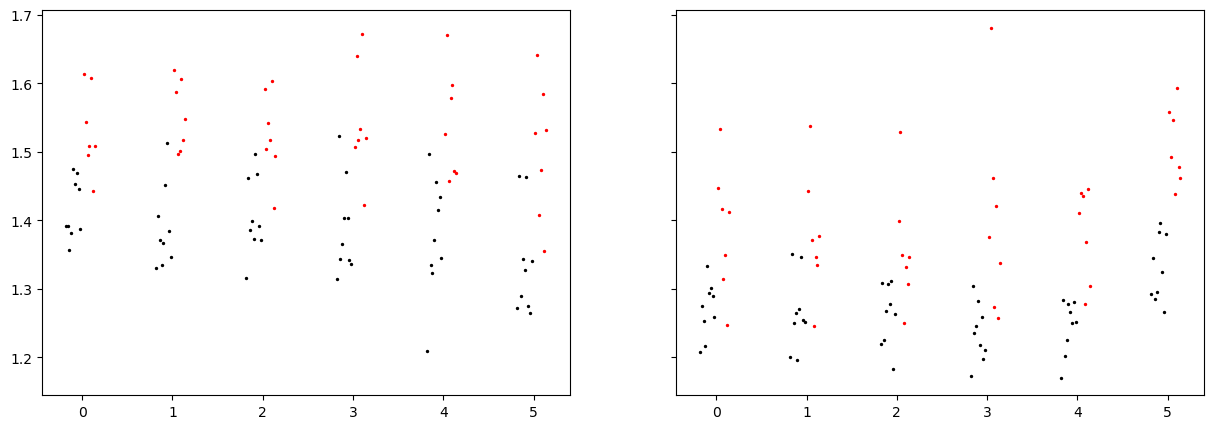

In [7]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=[15,5])

days = np.arange(6)
s=3
for m, mouse in enumerate(ctrl_mice):
    ax[0].scatter(days-.02*(m+1), ctrl_fam_nf[:,m], s=2, color='black')
    ax[1].scatter(days-.02*(m+1), ctrl_nov_nf[:,m], s=2, color='black')
    
for m, mouse in enumerate(ko_mice):
    ax[0].scatter(days+.02*(m+1), ko_fam_nf[:,m], s=2, color='red')
    ax[1].scatter(days+.02*(m+1), ko_nov_nf[:,m], s=2, color='red')

In [8]:
ctrl_fam_fw, ctrl_nov_fw, ko_fam_fw, ko_nov_fw = mouse_avg_plot_mats('field_widths')

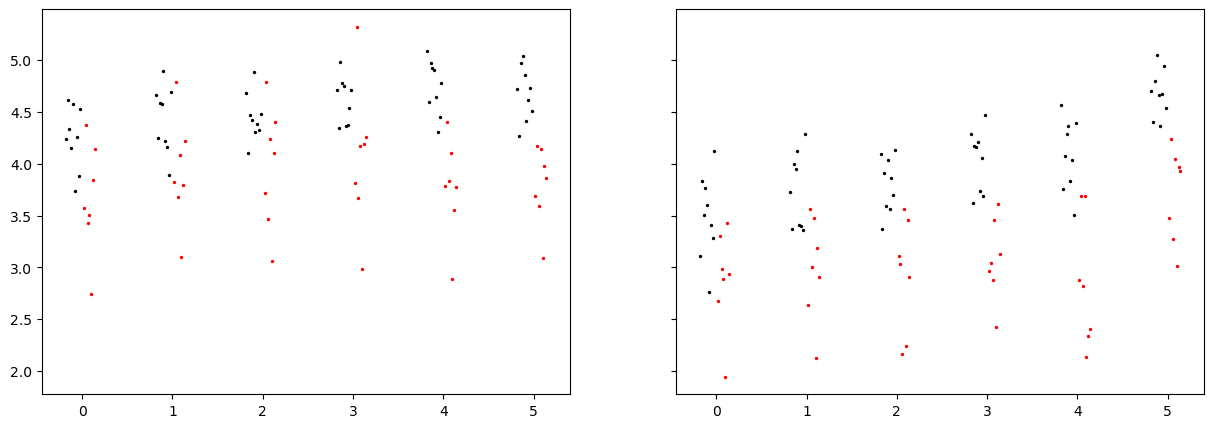

In [9]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=[15,5])

days = np.arange(6)
s=3
for m, mouse in enumerate(ctrl_mice):
    ax[0].scatter(days-.02*(m+1), ctrl_fam_fw[:,m], s=2, color='black')
    ax[1].scatter(days-.02*(m+1), ctrl_nov_fw[:,m], s=2, color='black')
    
for m, mouse in enumerate(ko_mice):
    ax[0].scatter(days+.02*(m+1), ko_fam_fw[:,m], s=2, color='red')
    ax[1].scatter(days+.02*(m+1), ko_nov_fw[:,m], s=2, color='red')

In [25]:
mouse = ctrl_mice[4]
sess = u.load_single_day(mouse,0)
res = ctrl_field_mask_res[mouse][0]['nov']

novmask = sess.trial_info['LR'] == sess.novel_arm
tmat = sess.trial_matrices['spks_norm'][novmask,:,:]

field_mask = res['field_mask']
fw = res['field_widths']
wide_fields = fw>5
rising, falling = res['rising_edges'][wide_fields,:], res['falling_edges'][wide_fields,:]


{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


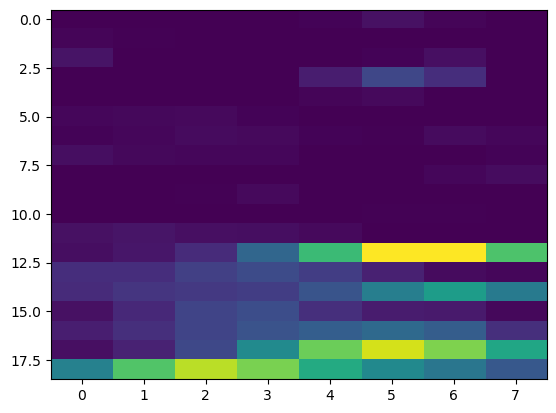

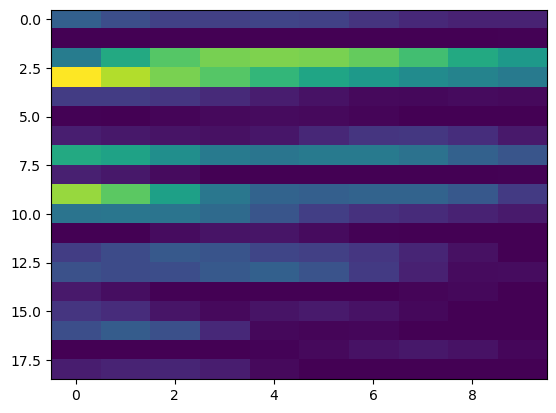

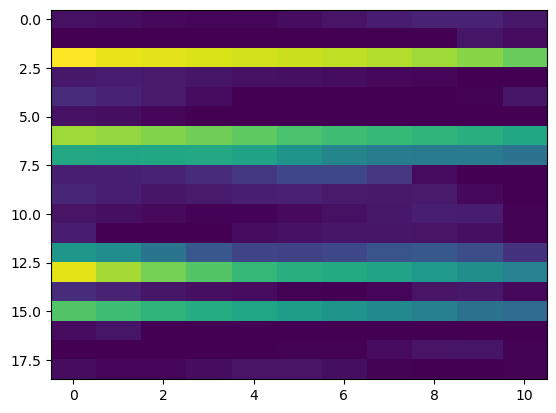

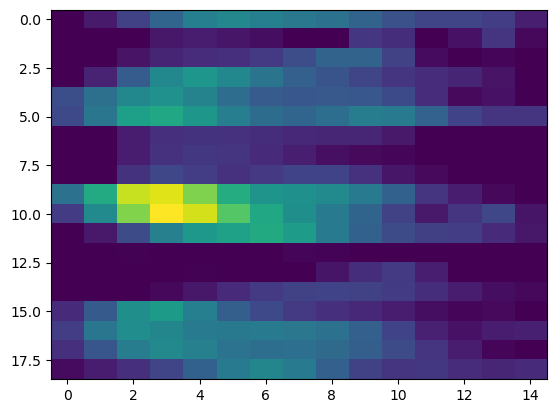

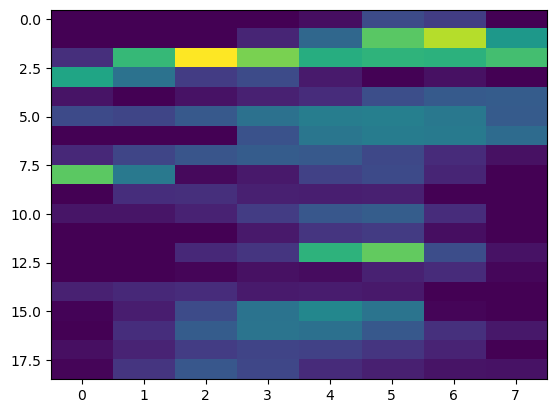

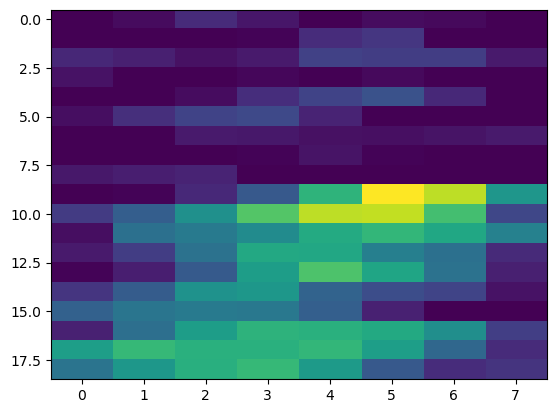

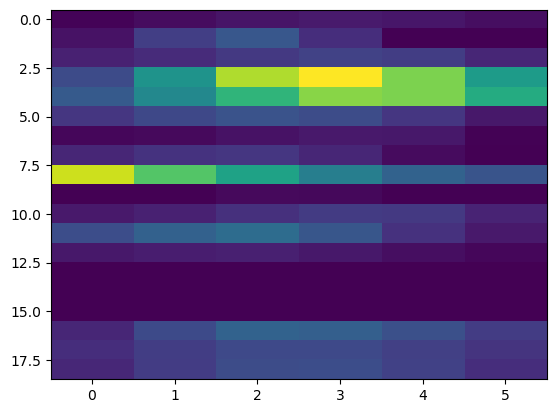

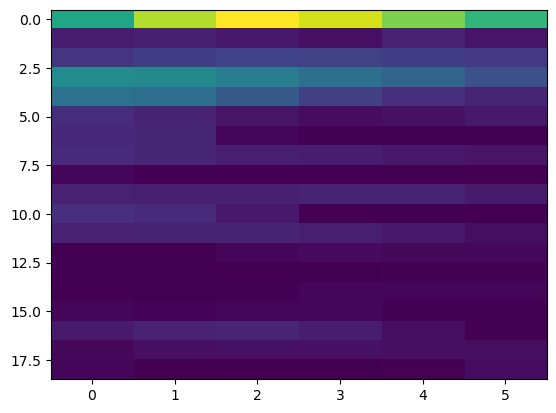

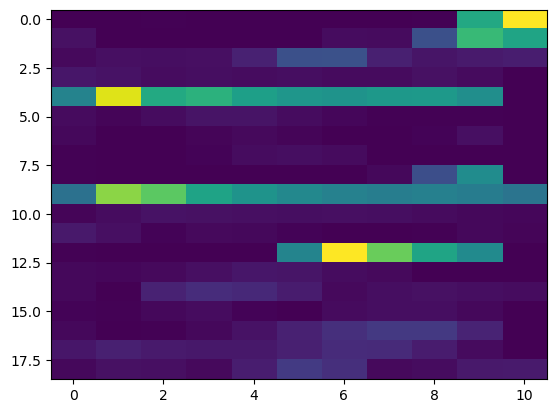

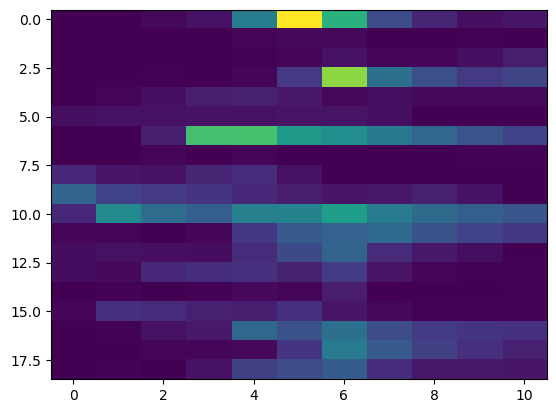

In [28]:
for field in range(10): #rising.shape[0]):
    cell, r, f = rising[field,0], rising[field,1], falling[field,1]
    field_tmat = tmat[:, r:f, cell]
    field_tmat[np.isnan(field_tmat)]=0
    
    fig,ax = plt.subplots()
    ax.imshow(field_tmat, aspect='auto', vmin = np.nanpercentile(field_tmat,20))

In [10]:
def get_field_com(rising, falling, tmat):
    COM = []
    for field in range(rising.shape[0]):
        cell, r, f = rising[field,0], rising[field,1], falling[field,1]
        f = np.minimum(f,29)
        field_tmat = tmat[:, r:f, cell]
        field_tmat[np.isnan(field_tmat)]=0

        pos_max = np.argmax(field_tmat.mean(axis=0))
        if (r == 0 and pos_max==0) or (f==29 and pos_max==field_tmat.shape[1]-1):
            pass
        else:
            # fig,ax = plt.subplots(1,2)


            thresh = .2*np.nanmax(field_tmat)
            thresh_mat = (field_tmat>thresh).sum(axis=-1)>0
            contig_mat = np.array([np.nansum(thresh_mat[i+1:i+6]) for i in range(thresh_mat.shape[0]-6)])>=3

            field_active_inds = np.arange(contig_mat.shape[0])[thresh_mat[:-6]*contig_mat]
            if field_active_inds.shape[0]>0:
                # ax[0].imshow(tmat[:, :, cell])
                # ax[1].plot(contig_mat)

                induction_lap = field_active_inds[0]
                active_trials = np.arange(induction_lap,field_tmat.shape[0])
                com = []
                for t in range(induction_lap,field_tmat.shape[0]):
                    _com = sp.ndimage.center_of_mass(field_tmat[t,:]+1E-3)
                    com.append(_com)
                    if np.isnan(_com):
                        print(field_tmat[t,:])
                com = np.array(com).ravel()
                COM.append(com)
    return COM
                
            # com = np.array([sp.ndimage.center_of_mass(field_tmat[i,:]) for i in range(induction_lap,field_tmat.shape[0])])
            # ax[0].plot(com+r,active_trials,color='red')

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
300
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
160
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
237
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
170
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
266
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
165
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 0}
118
{'date': '14_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 0}
132
{'date': '15_10_2021', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
99
{'date': '28_0

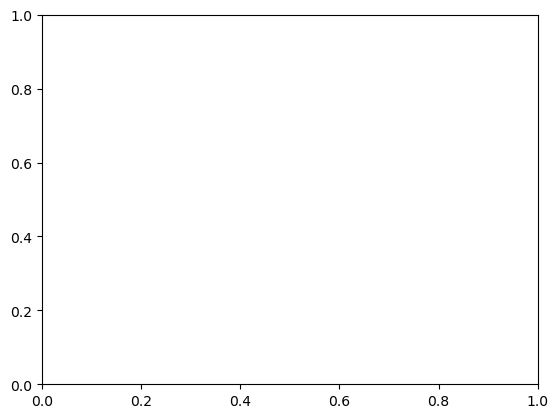

In [13]:
fig, ax = plt.subplots()

for mouse in ctrl_mice:
    sess = u.load_single_day(mouse,0)
    res = ctrl_field_mask_res[mouse][0]['nov']
    
    novmask = sess.trial_info['LR'] == sess.novel_arm
    tmat = sess.trial_matrices['spks_norm'][novmask,:,:]

    field_mask = res['field_mask']
    wide_fields = res['field_widths']>=5
    print(wide_fields.sum())
    rising, falling = res['rising_edges'][wide_fields,:], res['falling_edges'][wide_fields,:]
    
    COM = get_field_com(rising, falling, tmat)
    
    
    ctrl_shift = [] #np.nan*np.zeros([len(COM),5])
    for i,c in enumerate(COM):
        # print(c)
        ctrl_shift.append(c[0]-np.nanmean(c))
    #     shift[i,:]= c[:5]-np.nanmean(c)
    #     # ax.plot(c-c.mean())
    # ax.fill_between(np.arange(5), 
    #                 shift.mean(axis=0)-sp.stats.sem(shift,axis=0), 
    #                 y2=shift.mean(axis=0)+sp.stats.sem(shift,axis=0),
    #                 alpha=.3, color='black')
    # ax.plot(np.arange(5), 
    #                 shift.mean(axis=0),
    #                 color='black')
    
for mouse in ko_mice:
    sess = u.load_single_day(mouse,0)
    res = ko_field_mask_res[mouse][0]['nov']
    
    novmask = sess.trial_info['LR'] == sess.novel_arm
    tmat = sess.trial_matrices['spks_norm'][novmask,:,:]

    field_mask = res['field_mask']
    wide_fields = res['field_widths']>=5
    print(wide_fields.sum())
    rising, falling = res['rising_edges'][wide_fields,:], res['falling_edges'][wide_fields,:]
    
    COM = get_field_com(rising, falling, tmat)
    
    ko_shift = []
    # shift = np.nan*np.zeros([len(COM),5])
    for i,c in enumerate(COM):
        # print(c)
        # shift[i,:]= c[:5]-np.nanmean(c)
        ko_shift.append(c[0]-np.nanmean(c))
        # ax.plot(c-c.mean())
    # ax.fill_between(np.arange(5), 
    #                 shift.mean(axis=0)-sp.stats.sem(shift,axis=0), 
    #                 y2=shift.mean(axis=0)+sp.stats.sem(shift,axis=0),
    #                 alpha=.3, color='red')
    # ax.plot(np.arange(5), 
    #                 shift.mean(axis=0),
    #                 color='red')

-1.9808432689982218 0.049123554823799195


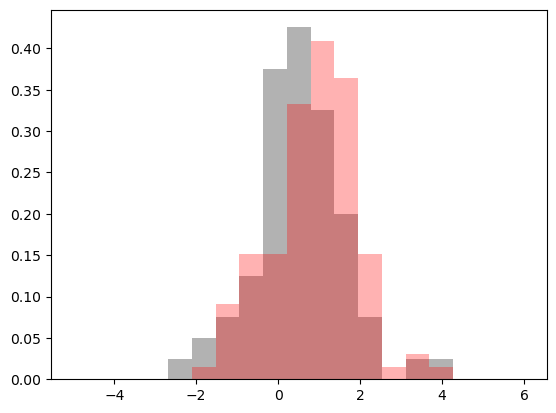

In [17]:
fig, ax = plt.subplots()

bins = np.linspace(-5,6, num=20)
ax.hist(ctrl_shift,bins=bins,color='black',alpha = .3, density=True)
ax.hist(ko_shift,bins=bins, color='red',alpha = .3, density=True)

t,p = sp.stats.ttest_ind(ctrl_shift, ko_shift)
print(t,p)

In [183]:
from sklearn.decomposition import PCA, NMF
proj = PCA().fit_transform(shift)

(279, 5)


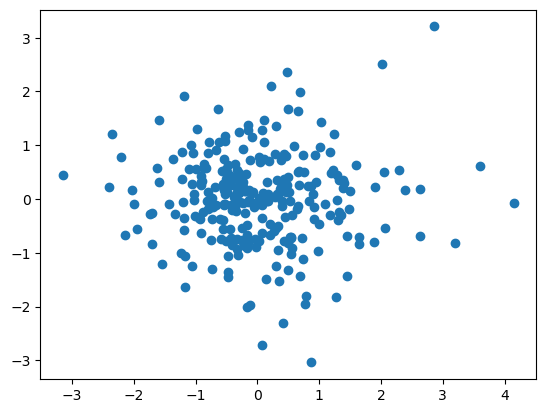

In [185]:
print(proj.shape)
fig, ax = plt.subplots()
ax.scatter(proj[:,0], proj[:,1])

In [168]:
# for each field

mouse = ctrl_mice[4]
sess = u.load_single_day(mouse,0)
res = ctrl_field_mask_res[mouse][0]['nov']
res.keys()
# if 

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


dict_keys(['field_mask', 'rising_edges', 'falling_edges', 'field_widths', 'num_fields'])

In [169]:

novmask = sess.trial_info['LR'] == sess.novel_arm
tmat = sess.trial_matrices['spks_norm'][novmask,:,:]

field_mask = res['field_mask']
wide_fields = res['field_widths']>=5
print(wide_fields.sum())
rising, falling = res['rising_edges'][wide_fields,:], res['falling_edges'][wide_fields,:]

232


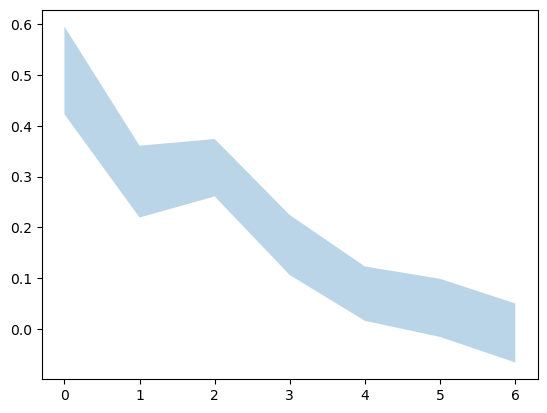

In [171]:
fig, ax = plt.subplots()
shift = np.nan*np.zeros([len(COM),10])
for i,c in enumerate(COM):
    # print(c)
    shift[i,:c.shape[0]]= c[:10]-np.nanmean(c[1:])
    # ax.plot(c-c.mean())
ax.fill_between(np.arange(10), 
                shift.mean(axis=0)-sp.stats.sem(shift,axis=0), 
                y2=shift.mean(axis=0)+sp.stats.sem(shift,axis=0),
                alpha=.3)

In [147]:
field_max = np.amax(field_tmat)

In [148]:
field_max

1.319787982738347

In [149]:
thresh = .05*field_max

In [156]:
thresh_mat = (field_tmat>thresh).sum(axis=-1)>0
contig_mat = np.array([thresh_mat[i+1:i+6].sum() for i in range(thresh_mat.shape[0]-6)])>=3

In [162]:
field_active_inds = np.arange(contig_mat.shape[0])[thresh_mat[:-6]*contig_mat]
induction_ind = field_active_inds[0]

In [165]:
com = np.array([sp.ndimage.center_of_mass(field_tmat[i,:]) for i in range(induction_ind,field_tmat.shape[0])])

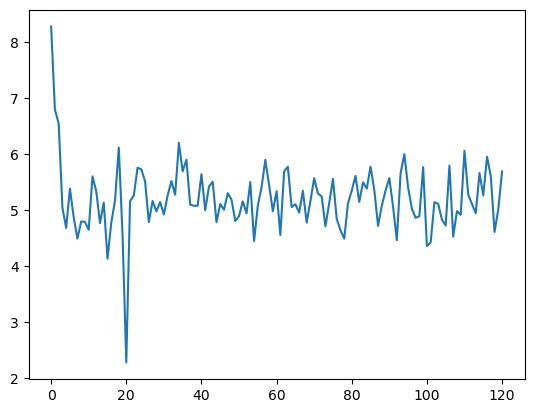

In [167]:
fig, ax = plt.subplots()
ax.plot(com)